In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline 

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, log_loss, roc_auc_score, roc_curve, RocCurveDisplay

In [2]:
df= pd.read_csv('../datasets/cleaned_data.csv')

In [3]:
df.isna().sum()/len(df)

Age of the patient                      0.0
Gender of the patient                   0.0
Total Bilirubin                         0.0
Direct Bilirubin                        0.0
 Alkphos Alkaline Phosphotase           0.0
 Sgpt Alamine Aminotransferase          0.0
Sgot Aspartate Aminotransferase         0.0
Total Protiens                          0.0
 ALB Albumin                            0.0
A/G Ratio Albumin and Globulin Ratio    0.0
Result                                  0.0
dtype: float64

In [4]:
df.duplicated().sum()

5658

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.describe()

,Age of the patient,Total Bilirubin,Direct Bilirubin,Alkphos Alkaline Phosphotase,Sgpt Alamine Aminotransferase,Sgot Aspartate Aminotransferase,Total Protiens,ALB Albumin,A/G Ratio Albumin and Globulin Ratio,Result
count,9363.000000,9363.000000,9363.000000,9363.000000,9363.000000,9363.000000,9363.000000,9363.000000,9363.000000,9363.000000
mean,43.831037,0.896422,0.269089,197.315254,29.160339,32.372288,6.613761,3.368155,1.023278,1.440350
std,16.321483,0.306738,0.177826,53.849055,12.246457,15.709620,1.018746,0.733239,0.250663,0.496456
min,4.000000,0.459806,0.100000,63.000000,10.000000,10.000000,3.600000,0.900000,0.300000,1.000000
25%,32.000000,0.700000,0.200000,163.000000,20.000000,21.000000,6.000000,2.900000,0.900000,1.000000
50%,45.000000,0.800000,0.200000,188.000000,26.000000,28.000000,6.700000,3.400000,1.000000,1.000000
75%,55.000000,1.000000,0.300000,215.000000,36.000000,41.000000,7.300000,4.000000,1.200000,2.000000
max,90.000000,2.200000,1.000000,418.000000,72.000000,95.000000,9.200000,5.500000,1.800000,2.000000


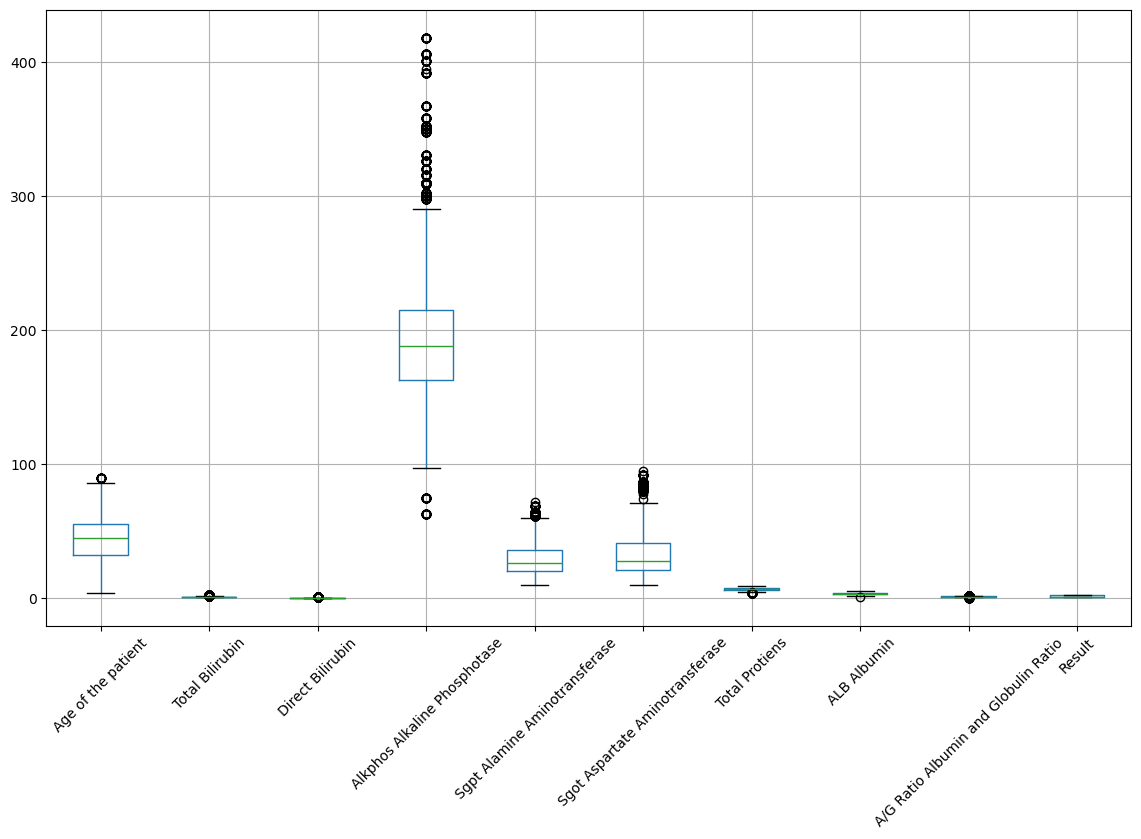

In [7]:
plt.figure(figsize=(14,8))
df.boxplot()
plt.xticks(rotation=45)
plt.show()

### imputing missing values

In [8]:
df.isna().sum() / len(df)

Age of the patient                      0.0
Gender of the patient                   0.0
Total Bilirubin                         0.0
Direct Bilirubin                        0.0
 Alkphos Alkaline Phosphotase           0.0
 Sgpt Alamine Aminotransferase          0.0
Sgot Aspartate Aminotransferase         0.0
Total Protiens                          0.0
 ALB Albumin                            0.0
A/G Ratio Albumin and Globulin Ratio    0.0
Result                                  0.0
dtype: float64

### label representation
- "1" likely represents a patient with liver disease (positive case).
- "2" likely represents a healthy patient (negative case).

In [9]:
# split features and label
X= df.iloc[:,:-1]
y= df.iloc[:,-1]

#split train and test set
X_train,X_test,y_train,y_test= train_test_split(X,y, test_size=0.2, random_state=6)

In [10]:
cat_cols= X.select_dtypes(include='object').columns
numeric_cols= X.select_dtypes(exclude='object').columns

# preprocessing for numeric features 
numeric_preprocessor= Pipeline(steps= [
    ('imputer',SimpleImputer(strategy='mean')),        
    ('scaler', StandardScaler())
])

# preprocessing for categorical feature
categorical_preprocessor= Pipeline(steps=[
    ('cat_impute',SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False)), 
])

# combine both numeric and categorical transformer 
preprocessor = ColumnTransformer(transformers=[
    ('num-pipeline', numeric_preprocessor, numeric_cols),    
    ('cat-pipeline', categorical_preprocessor, cat_cols)],
                                 remainder='passthrough')

# create a pipeline for preprocessing and model training
pipeline = Pipeline(steps=[
    ('preprocess',preprocessor),
    ('model',LogisticRegression())
])

del_y_train= y_train
del_y_test= y_test

# encode label as [0,1] form [1,2]
label_encoder= LabelEncoder()
y_train= label_encoder.fit_transform(y_train)
y_test= label_encoder.transform(y_test)

pipeline.fit(X_train,y_train).score(X_train,y_train)

0.5941255006675568

- pipeline - works squentially (one after another)
- column transformer - works parallelly

In [11]:
X_train= preprocessor.fit_transform(X_train)
X_test= preprocessor.transform(X_test)

In [12]:
def show_scores(model, X_train,X_test,y_train,y_test):
    model.fit(X_train,y_train)
    train_preds= model.predict(X_train)
    test_preds= model.predict(X_test)
    print('Train accuracy',accuracy_score(y_train,train_preds))
    print('Test accuracy',accuracy_score(y_test,test_preds))
    print('Train classification \n\n',classification_report(y_train,train_preds))
    print('Test classification \n\n',classification_report(y_test,test_preds))
    

In [13]:
log_reg= LogisticRegression()
knn= KNeighborsClassifier()
gauss= GaussianNB()
tree_model= DecisionTreeClassifier()
rf_model= RandomForestClassifier()

for model in [log_reg, knn, gauss, tree_model, rf_model]:
    print('\n',model)
    show_scores(model, X_train, X_test,y_train,y_test)
    


 LogisticRegression()
Train accuracy 0.5941255006675568
Test accuracy 0.589428723972237
Train classification 

               precision    recall  f1-score   support

           0       0.61      0.77      0.68      4198
           1       0.56      0.37      0.45      3292

    accuracy                           0.59      7490
   macro avg       0.58      0.57      0.56      7490
weighted avg       0.59      0.59      0.58      7490

Test classification 

               precision    recall  f1-score   support

           0       0.60      0.76      0.67      1042
           1       0.55      0.38      0.45       831

    accuracy                           0.59      1873
   macro avg       0.58      0.57      0.56      1873
weighted avg       0.58      0.59      0.57      1873


 KNeighborsClassifier()
Train accuracy 0.9748998664886516
Test accuracy 0.9551521623064603
Train classification 

               precision    recall  f1-score   support

           0       0.98      0.97      

In [14]:
del_model= RandomForestClassifier()
del_model.fit(X_train, del_y_train)
del_predictions = del_model.predict(X_test)

In [15]:
test_model= RandomForestClassifier()
test_model.fit(X_train, y_train)
predictions = test_model.predict(X_test)

In [16]:
accuracy_score(del_y_test, del_predictions), accuracy_score(y_test, predictions)

(0.99786438868126, 0.996262680192205)

In [17]:
print('accuracy: ', accuracy_score(y_test, predictions))
print('precision: ', precision_score(y_test, predictions))
print('recall: ', recall_score(y_test, predictions))

accuracy:  0.996262680192205
precision:  0.9951923076923077
recall:  0.9963898916967509


In [18]:
recall_score(y_test, predictions)

0.9963898916967509

In [19]:
set(predictions)

{0, 1}

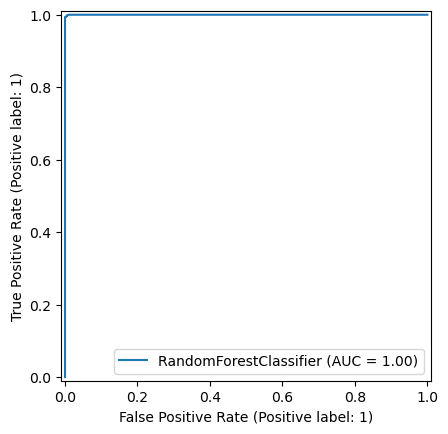

In [20]:
RocCurveDisplay.from_estimator(test_model, X_test, y_test)

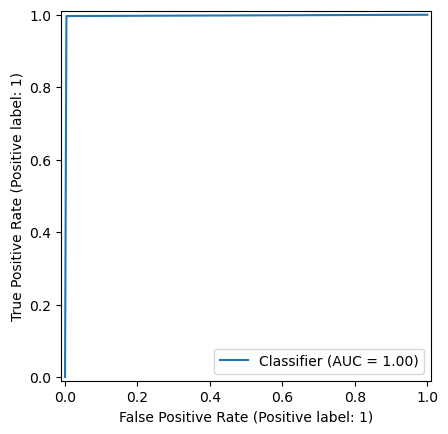

In [21]:
RocCurveDisplay.from_predictions(y_test,predictions)

In [22]:
confusion_matrix(y_test, predictions)

array([[1038,    4],
       [   3,  828]], dtype=int64)

Summary: Out of 2793 type 1(positive for disease) cases which is sensitive, the model is able to predict 2790 cases as correct and misleading 3 cases with accuracy of 
0.99 % which is good.

In [23]:
from xgboost import XGBClassifier
xg_boost= XGBClassifier()
xg_boost.fit(X_train,y_train)
xg_pred= xg_boost.predict(X_test)

In [24]:
r2_score(y_test,xg_pred)

0.9956738753346221

In [25]:
print(classification_report(del_y_test, del_predictions))
print(classification_report(y_test, predictions))
print(classification_report(y_test, xg_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1042
           2       1.00      1.00      1.00       831

    accuracy                           1.00      1873
   macro avg       1.00      1.00      1.00      1873
weighted avg       1.00      1.00      1.00      1873

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1042
           1       1.00      1.00      1.00       831

    accuracy                           1.00      1873
   macro avg       1.00      1.00      1.00      1873
weighted avg       1.00      1.00      1.00      1873

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1042
           1       1.00      1.00      1.00       831

    accuracy                           1.00      1873
   macro avg       1.00      1.00      1.00      1873
weighted avg       1.00      1.00      1.00      1873



In [26]:
print('accuracy: ', accuracy_score(del_y_test, del_predictions))
print('precision: ', precision_score(del_y_test, del_predictions))
print('recall: ', recall_score(del_y_test, del_predictions))
print('\n')
print('accuracy: ', accuracy_score(y_test, predictions))
print('precision: ', precision_score(y_test, predictions))
print('recall: ', recall_score(y_test, predictions))
print('\n')
print('accuracy: ', accuracy_score(y_test, xg_pred))
print('precision: ', precision_score(y_test, xg_pred))
print('recall: ', recall_score(y_test, xg_pred))
print('\n')
print('without label',log_loss(del_y_test, del_predictions))
print('with label ', log_loss(y_test, predictions ))
print('xg_boost with label', log_loss(y_test,xg_pred))

accuracy:  0.99786438868126
precision:  0.9980806142034548
recall:  0.9980806142034548


accuracy:  0.996262680192205
precision:  0.9951923076923077
recall:  0.9963898916967509


accuracy:  0.99893219434063
precision:  0.9987966305655837
recall:  0.9987966305655837


without label 20.052048495173555
with label  0.13470665975644447
xg_boost with label 0.03848761707327


In [27]:
print('without label',log_loss(del_y_test, del_predictions))
print('with label ', log_loss(y_test, predictions ))
print('xg_boost with label', log_loss(y_test,xg_pred))

without label 20.052048495173555
with label  0.13470665975644447
xg_boost with label 0.03848761707327


In [28]:
print(confusion_matrix(del_y_test, del_predictions))
print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, xg_pred))

[[1040    2]
 [   2  829]]
[[1038    4]
 [   3  828]]
[[1041    1]
 [   1  830]]
